# TRUSTWORTHY AI: Robustness and safety Requirement

#### Script to ensure the Robustness and safety requirement for a dataset. Based on EU guidelines.
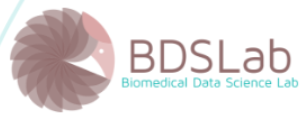


## TABLE OF CONTENTS:

<div class="alert" style="margin-top: 20px">

1. [Data preparation](#data-preparation)<br>
1.1. [Data pre-processing](#data-pre-processing)<br>
1.2. [Data quality control](#data-quality-control)<br>

2. [Model Development](#model-development)<br>
2.1. [Design & Training](#design-training)<br>
2.2. [Evaluation](#evaluation)<br>

3. [Deployment & Use](#deployment-use)<br>


[References](#references)
</div>


The key requirement of Robustness and safety covers four main concepts:

* **Resilience to attack and security:** protect against vulnerabilities that can be exploited by adversaries.
*  **Fallback plan and general safety:** safeguards to minimise errors.
*  **Accuracy:** make juices properly. If inaccuracies cannot be avoided, indicate the probability of occurrence.
*  **Realiability and reproducibility:** ensure that the IA works properly within an interval and is able to maintain its behaviour under the same conditions.

We start by preparing the working environment. Import all the necessary libraries.

In [63]:
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.calibration import calibration_curve
from sklearn.utils import resample

from imblearn.over_sampling import SMOTENC

from functions.NaiveBayesMixed import NaiveBayesMixed
from functions.handleData import handleData

Load the dataset and define Metadata

In [64]:
path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\BECA COLABORACIÓN\\Datasets\\Heart Disease\\' 
file_name = 'dataset_train_heart_disease_QC.csv'
data = pd.read_csv(path + file_name)

# Create a subset to work more efficiently
# data = data.sample(frac = 0.2, random_state=100) 


In [65]:
data[output].value_counts()

target
1    560
0    510
Name: count, dtype: int64

In [66]:
# Define Metadata
dataset = data
output = "target"
positive_class = ""
feat_id = ""
feat_sensitive = ["sex"]
feat_types = {
    "age": "numerical",
    "sex": "categorical",
    "chest pain type": "categorical",
    "resting bp s": "numerical",
    "cholesterol": "numerical",
    "fasting blood sugar": "categorical",
    "resting ecg": "categorical",
    "max heart rate":"numerical",
    "exercise angina":"categorical",
    "oldpeak":"numerical",
    "ST slope":"categorical",
}
feat2balance = ["sex"]
data_provenance = "The dataset consists of 1190 records of patients from US, UK, Switzerland and Hungary."

In [67]:
### Uncomment only if you want to binarise a multi-class classification problem ###
if positive_class:
    dataset[output] = pd.Series(np.where(dataset[output] == positive_class, 1, 0), index=dataset[output].index, name=output)

features_df = dataset.drop(output,axis=1)
tags_df = dataset[output] 
unique_classes = np.unique(tags_df)
n_classes = len(unique_classes)
feat_num = [col for col, type in feat_types.items() if type == "numerical"]
feat_cat = [col for col, type in feat_types.items() if type == "categorical"]
feature_names = features_df.columns

handleData = handleData(feat_num, feat_cat)

## 1. DATA PREPARATION  <a class="anchor" id="data-preparation"></a>

### 1.1. Data Pre-processing: <a class="anchor" id="data-pre-processing"></a>

To deal with the curse of dimensionality it would be useful to implement a `Feature selection or Dimension reduction` step [1].

### 1.2. Data Quality Control: <a class="anchor" id="data-quality-control"></a>

If your classes are unbalaced, you can use `Class balancing` methods such as oversampling or downsampling [2]. In our case, we will use SMOTENC during the training to balance the classes.

## 2. MODEL DEVELOPMENT <a class="anchor" id="model-development"></a>
### 2.1. Design & Training  <a class="anchor" id="design-training"></a>

In [68]:
features_df_encoded, features_names_encoded, feat_cat_encoded = handleData.encode(features_df)
feat_train, feat_test, tags_train, tags_test = train_test_split(features_df_encoded, tags_df, test_size=0.2, random_state = 1)

In [69]:
tags_train.value_counts()

target
1    456
0    400
Name: count, dtype: int64

In [70]:
model_RandomForest = RandomForestClassifier(random_state=1)
model_MixedNB = NaiveBayesMixed(feat_num, feat_cat_encoded)

classifiers = {'RF': model_RandomForest, 'NB': model_MixedNB}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple', 'brown', 'pink', 'gray']


A `Well-formed evaluation` is required, which would include cross-validation (CV) [3], cost functions and robust metrics. Before training the full model, you can search for better parameters of the model with a `Hyperparameter Optimization` step. In particular, we use GridSearch [4] within CV to optimize Random Forest hyperparameters. Ideally, GridSearch would include an oversampling step within its loop. However, due to its complexity, we fit the GridSearch CV with oversampled data. If you have enough data, you can use this approach with Hold Out.

Best parameters average for RF: {'max_depth': 20.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 150.0}


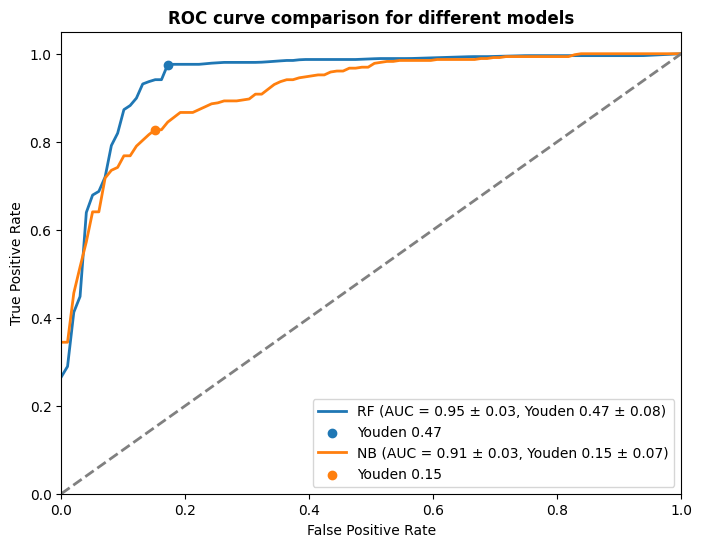

In [71]:
youden_index = {classifier_name: [] for classifier_name in classifiers.keys()}
trained_models = {classifier_name: [] for classifier_name in classifiers.keys()}

param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [20, 30, 40],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

skf = StratifiedKFold(n_splits=5)
smotenc = SMOTENC(categorical_features=feat_cat, random_state=1)

plt.figure(figsize=(8, 6))

for i, (classifier_name, classifier) in enumerate(classifiers.items()):
    color = colors[i % len(colors)]

    youden_indexes = []
    auc_folds = []
    tpr_folds = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train_index, test_index in skf.split(feat_train, tags_train):
        X_train, X_test = feat_train.iloc[train_index], feat_train.iloc[test_index]  
        y_train, y_test = tags_train.iloc[train_index], tags_train.iloc[test_index]

        X_train_decoded = handleData.decode(X_train)
        X_train_over_decoded, y_train_over = smotenc.fit_resample(X_train_decoded, y_train)
        X_train_over, _, _ = handleData.encode(X_train_over_decoded)

        best_params = []

        if classifier_name == 'RF':
            grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='roc_auc')

            grid_search.fit(X_train_over, y_train_over)
            best_params.append(grid_search.best_params_)
        
        classifier.fit(X_train_over, y_train_over)
        trained_models[classifier_name].append(classifier)
        y_pred_prob = classifier.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
        tpr_folds.append(np.interp(mean_fpr, fpr, tpr))
        
        roc_auc = auc(fpr, tpr)
        auc_folds.append(roc_auc)
        
        youden_fold = thresholds[np.argmax(tpr - fpr)]
        youden_indexes.append(youden_fold)

    if classifier_name == 'RF':
        avg_best_params = {}
        for param in best_params[0].keys():
            avg_best_params[param] = np.mean([params[param] for params in best_params])

        print(f"Best parameters average for {classifier_name}: {avg_best_params}")

    mean_tpr = np.mean(tpr_folds, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    youden_index[classifier_name] = np.mean(youden_indexes)
    
    auc_std = np.std(auc_folds)
    youden_std = np.std(youden_indexes)
    
    plt.plot(mean_fpr, mean_tpr, color=color, lw=2, label=f'{classifier_name} (AUC = {mean_auc:.2f} ± {auc_std:.2f}, Youden {youden_index[classifier_name]:.2f} ± {youden_std:.2f})')
    plt.scatter(mean_fpr[np.argmax(mean_tpr - mean_fpr)], mean_tpr[np.argmax(mean_tpr - mean_fpr)], color=color, marker='o', label=f'Youden {youden_index[classifier_name]:.2f}')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontdict={'fontsize':10})
plt.ylabel('True Positive Rate', fontdict={'fontsize':10})
plt.title('ROC curve comparison for different models', fontdict={'fontsize':12, 'weight': 'bold'})
plt.legend(loc="lower right", prop={'size':10})
plt.show()

### 2.2. Evaluation  <a class="anchor" id="evaluation"></a>

Once cross-validation is done with the training subset, we can do its validation with the test subset.

In [74]:
# model_RandomForest = RandomForestClassifier(random_state=1, **avg_best_params)
model_RandomForest = RandomForestClassifier(random_state=1, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150)

model_MixedNB = NaiveBayesMixed(feat_num, feat_cat_encoded)

classifiers = {'RF': model_RandomForest, 'NB': model_MixedNB}
youden_index = {classifier_name: [] for classifier_name in classifiers.keys()}
youden_index['RF']=0.2
youden_index['NB']=0.1

Final model evaluation for RF on test set:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       110
           1       0.75      0.97      0.85       104

    accuracy                           0.83       214
   macro avg       0.86      0.83      0.82       214
weighted avg       0.86      0.83      0.82       214

Final model evaluation for NB on test set:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       110
           1       0.77      0.81      0.79       104

    accuracy                           0.79       214
   macro avg       0.79      0.79      0.79       214
weighted avg       0.79      0.79      0.79       214



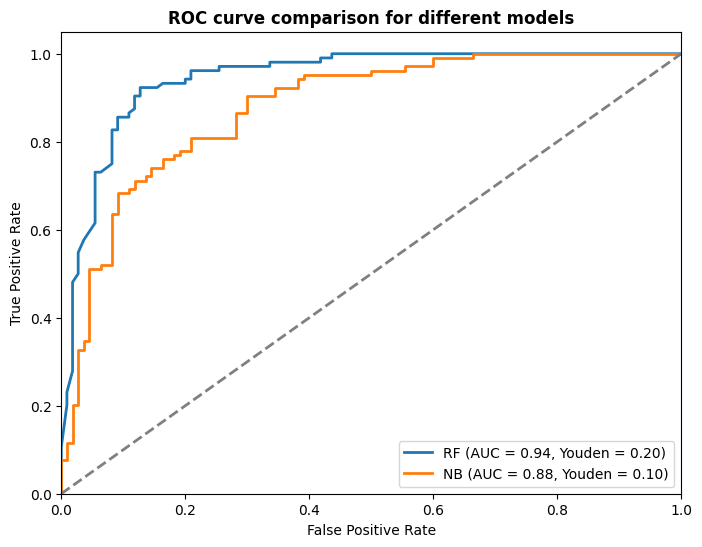

In [75]:
plt.figure(figsize=(8, 6))

for i, (classifier_name, classifier) in enumerate(classifiers.items()):
    color = colors[i % len(colors)]

    classifier.fit(feat_train, tags_train)
    proba_pred = classifier.predict_proba(feat_test)

    fpr, tpr, _ = roc_curve(tags_test, proba_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{classifier_name} (AUC = {roc_auc:.2f}, Youden = {youden_index[classifier_name]:.2f})')

    tags_pred = np.where(proba_pred[:, 1] >= youden_index[classifier_name], 1, 0)
    print(f"Final model evaluation for {classifier_name} on test set:")
    print(classification_report(tags_test, tags_pred))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontdict={'fontsize':10})
plt.ylabel('True Positive Rate', fontdict={'fontsize':10})
plt.title('ROC curve comparison for different models', fontdict={'fontsize':12, 'weight': 'bold'})
plt.legend(loc="lower right", prop={'size':10})
plt.show()


To quantify the consistency of your model you must include an `Uncertainty quantification in metrics`. Using bootstrap methods you can train differents models and offer a confidence interval help quantify the certainty of your metrics.

In [76]:
n_bootstraps = 5
trained_models_BT = {classifier_name: [] for classifier_name in classifiers.keys()}

# Bootstrap resampling
for classifier_name, classifier in classifiers.items():

    sensitivity_scores = []
    specificity_scores = []
    f1_scores = []
    bootstrap_models = []

    for boot in range(n_bootstraps):

        # Generate bootstrap sample
        feat_train_resampled, tags_train_resampled = resample(feat_train, tags_train, n_samples=int(0.8 * len(feat_train)), replace=True, random_state=boot)
        classifier.fit(feat_train_resampled, tags_train_resampled)
        bootstrap_models.append(classifier) 
        
        proba_pred = classifier.predict_proba(feat_test)
        tags_pred = np.where(proba_pred[:, 1] >= youden_index[classifier_name], 1, 0)
        conf_matrix = confusion_matrix(tags_test, tags_pred)
        
        TP = np.diag(conf_matrix) 
        FP = conf_matrix.sum(axis=0) - TP 
        FN = conf_matrix.sum(axis=1) - TP
        TN = conf_matrix.sum() - (TP + FP + FN) 
    
        sensitivity = np.mean(TP / (TP + FN))
        specificity = np.mean(TN / (TN + FP))
        f1_result = f1_score(tags_test, tags_pred, average='weighted') 
        
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
        f1_scores.append(f1_result)
        trained_models_BT[classifier_name].append(classifier)

    print(f"Bootstrap Resampling Results for {classifier_name}:")
    print(f"- Mean Sensitivity: {np.mean(sensitivity_scores) * 100:.2f}%, Std Sensitivity: {np.std(specificity_scores) * 100:.2f}%")
    print(f"- Mean Specificity: {np.mean(specificity_scores) * 100:.2f}%, Std Specificity: {np.std(specificity_scores)  * 100:.2f}%")
    print(f"- Mean F1-score: {np.mean(f1_scores) * 100:.2f}%, Std F1-score: {np.std(f1_scores)* 100:.2f}% \n")


Bootstrap Resampling Results for RF:
- Mean Sensitivity: 80.22%, Std Sensitivity: 1.07%
- Mean Specificity: 80.22%, Std Specificity: 1.07%
- Mean F1-score: 79.44%, Std F1-score: 1.13% 

Bootstrap Resampling Results for NB:
- Mean Sensitivity: 79.09%, Std Sensitivity: 0.70%
- Mean Specificity: 79.09%, Std Specificity: 0.70%
- Mean F1-score: 79.06%, Std F1-score: 0.75% 



A calibration curve might also provide some useful information.

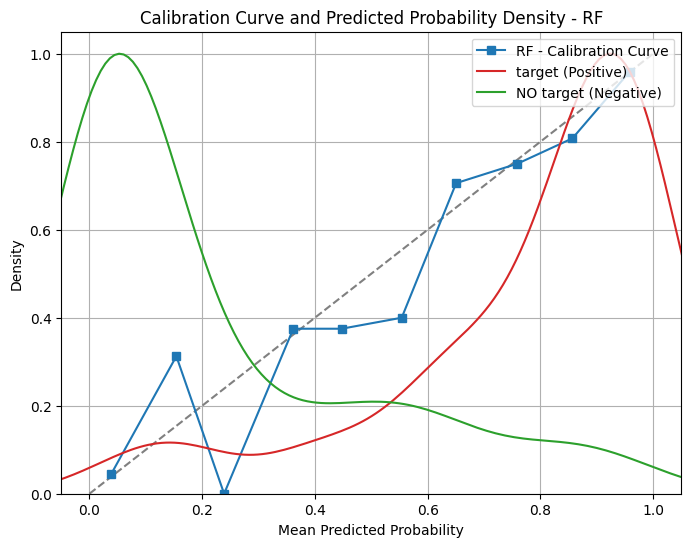

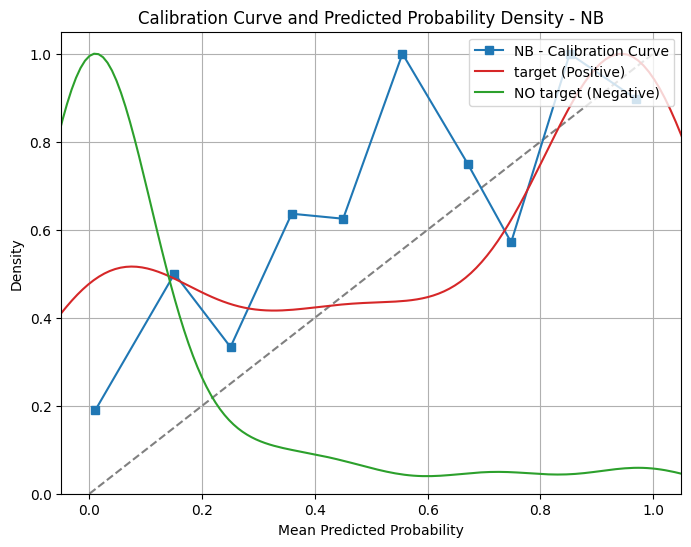

In [77]:
for classifier_name, classifier in classifiers.items():

    plt.figure(figsize=(8, 6))

    # Obtain predicted probabilities
    prob_pos = classifier.predict_proba(feat_test)[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(tags_test, prob_pos, n_bins=10)

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.plot(mean_predicted_value, fraction_of_positives, marker='s', color=colors[0], linestyle='-', label=f'{classifier_name} - Calibration Curve')

    # Density plot for positive and negative predictions
    sns.kdeplot(prob_pos[tags_test == 1], color=colors[3], label=f'{output} (Positive)', linestyle='-')
    sns.kdeplot(prob_pos[tags_test == 0], color=colors[2], label=f'NO {output} (Negative)', linestyle='-')
    
    # Normalize the KDE
    plt.gca().get_lines()[-2].set_ydata(plt.gca().get_lines()[-2].get_ydata() / plt.gca().get_lines()[-2].get_ydata().max())
    plt.gca().get_lines()[-1].set_ydata(plt.gca().get_lines()[-1].get_ydata() / plt.gca().get_lines()[-1].get_ydata().max())

    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Calibration Curve and Predicted Probability Density - {classifier_name}')
    plt.grid(True)
    plt.legend(fontsize='medium', loc='upper right')
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 1.05) 
    plt.show()


## 3. DEPLOYMENT & USE <a class="anchor" id="deployment-use"></a>

It is important to consider `Uncertainty quantification` methods [5]. We offer two insights: evaluating consistency between models for the same sample (Bayesian) and in a model for a perturbed sample (Augmentation).

#### Bayesian

In [78]:
file_name = 'dataset_test_heart_disease_QC.csv'
data_test = pd.read_csv(path + file_name)

feat_test = data_test.drop(output,axis=1)
feat_test, _, _ = handleData.encode(feat_test)
tags_test = pd.Series(np.where(data_test[output] == positive_class, 1, 0), index=data_test[output].index, name=output)

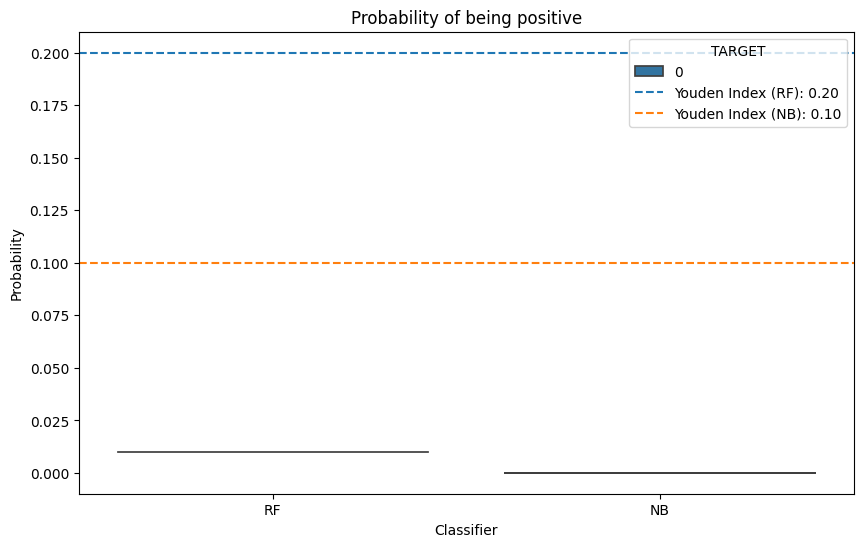

In [79]:
random_samples = handleData.get_random_samples(feat_test, tags_test)

samples = []
classes = []
probabilities = []

for classifier_name, model_info in trained_models.items():
    for model in model_info:
        for tag, rdm_feat in random_samples.items():

            prob = model.predict_proba(rdm_feat)[:, 1] 
            probabilities.extend(prob)
            classes.extend([classifier_name] * len(prob))
            samples.extend([tag] * len(prob))

probabilities_df = pd.DataFrame({'Sample': samples, 'Class': classes, 'Probability': probabilities})

plt.figure(figsize=(10, 6))
sns.violinplot(x='Class', y='Probability', hue='Sample', data=probabilities_df, split=True, inner='quart')
plt.axhline(y=youden_index['RF'], color='tab:blue', linestyle='--', label=f'Youden Index (RF): {youden_index["RF"]:.2f}')  # Línea vertical en el índice de Youden para RF
plt.axhline(y=youden_index['NB'], color='tab:orange', linestyle='--', label=f'Youden Index (NB): {youden_index["NB"]:.2f}')  # Línea vertical en el índice de Youden para RF
plt.title('Probability of being positive')
plt.ylabel('Probability')
plt.xlabel('Classifier')
plt.legend(title=output.upper(), loc='upper right')
plt.show()


#### Augmentation
We use this method to estimate a 95% confidence interval. If the Youden index is within the CI threshold, the classification may be inaccurate.

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.36       100
           1       0.00      1.00      0.00         0

    accuracy                           0.22       100
   macro avg       0.50      0.61      0.18       100
weighted avg       1.00      0.22      0.36       100



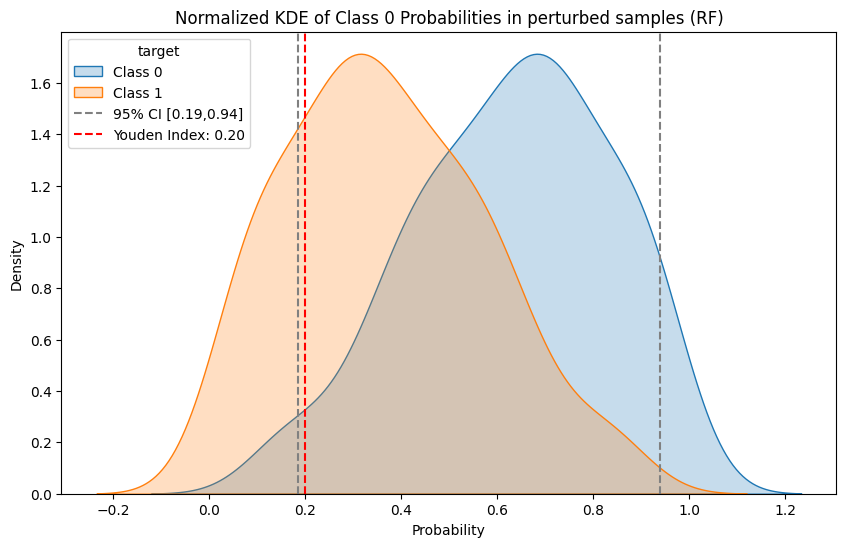

In [97]:
times = 100
for tag, rdm_feat in random_samples.items():

    # Obtain perturbed samples
    sample_augmentation = handleData.decode(rdm_feat)
    augmented_samples = handleData.perturb_sample(sample_augmentation.iloc[0,:], features_df, times)
    augmented_samples_enc, _, _ = handleData.encode(augmented_samples)

    proba_pred = model_RandomForest.predict_proba(augmented_samples_enc)
    tags_pred = np.where(proba_pred[:, 1] >= youden_index['RF'], 1, 0)
    tags_augmented = np.repeat(tag, 100)  # Repeat label for each perturbed sample
    print("Classification Report:\n", classification_report(tags_augmented, tags_pred, zero_division=1))

    # Obtain probabilities per class
    class_probabilities = [[] for _ in range(len(model_RandomForest.classes_))] 
    for prob in proba_pred:
        for i, p in enumerate(prob):
            class_probabilities[i].append(p)

    # Plot KDE
    plt.figure(figsize=(10, 6))
    for i, class_prob in enumerate(class_probabilities):
        sns.kdeplot(class_prob, label=f'Class {model_RandomForest.classes_[i]}', fill=True, common_norm=True)

    # Calculate percentiles 2.5 and 97.5
    percentile_2_5 = np.percentile(class_probabilities[tag], 2.5)
    percentile_97_5 = np.percentile(class_probabilities[tag], 97.5)

    # Plot percentile
    plt.axvline(x=percentile_2_5, color='gray', linestyle='--', label=f'95% CI [{percentile_2_5:.2f},{percentile_97_5:.2f}]')
    plt.axvline(x=percentile_97_5, color='gray', linestyle='--')

    # Plot Youden index
    plt.axvline(x=youden_index['RF'], color='red', linestyle='--', label=f'Youden Index: {youden_index['RF']:.2f}')

    plt.title(f'Normalized KDE of Class {tag} Probabilities in perturbed samples (RF)')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend(title=output)
    plt.show()


You can also evaluate the consistency with the outliers identified during data preparation. 

In [85]:
try:
    file_name = 'outliers_multivariate.csv'
    outliers = pd.read_csv(path + file_name)

    # Binarize output and separate into features and tags
    outliers[output] = pd.Series(np.where(outliers[output] == positive_class, 1, 0), index=outliers[output].index, name=output)
    feat_outliers = outliers.drop(output,axis=1)
    feat_outliers_encoded, _, _ = handleData.encode(feat_outliers)
    tags_outliers = outliers[output] 

    # Identify missing categories in the outliers
    categories_A = set(feat_test.columns)
    categories_B = set(feat_outliers_encoded.columns)
    missing_categories = categories_A - categories_B

    for category in missing_categories:
        feat_outliers_encoded[category] = 0

    feat_outliers_encoded = feat_outliers_encoded.reindex(feat_test.columns, axis=1)

    proba_pred = model_RandomForest.predict_proba(feat_outliers_encoded)
    tags_pred = np.where(proba_pred[:, 1] >= youden_index['RF'], 1, 0)

    print("Classification Report:\n", classification_report(tags_outliers, tags_pred, zero_division=1))

except:
    print("There are no multivariate outliers")

There are no multivariate outliers


## REFERENCES  <a class="anchor" id="references"></a>

1. Karanam, S. (2021, agosto 11). Curse of Dimensionality—A “Curse” to Machine Learning. Medium. https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb <br>

2. lreedy, D., & Atiya, A. F. (2019). A Comprehensive Analysis of Synthetic Minority Oversampling Technique (SMOTE) for handling class imbalance. Information Sciences, 505, 32-64. https://doi.org/10.1016/j.ins.2019.07.070 <br>

3. Bradshaw, T. J., Huemann, Z., Hu, J., & Rahmim, A. (2023). A Guide to Cross-Validation for Artificial Intelligence in Medical Imaging. Radiology: Artificial Intelligence, 5(4), e220232. https://doi.org/10.1148/ryai.220232 <br>

4. Belete, D., & D H, M. (2021). Grid search in hyperparameter optimization of machine learning models for prediction of HIV/AIDS test results. International Journal of Computers and Applications, 44, 1-12. https://doi.org/10.1080/1206212X.2021.1974663 <br>

5. Abdar, M., Pourpanah, F., Hussain, S., Rezazadegan, D., Liu, L., Ghavamzadeh, M., Fieguth, P., Cao, X., Khosravi, A., Acharya, U. R., Makarenkov, V., & Nahavandi, S. (2021). A review of uncertainty quantification in deep learning: Techniques, applications and challenges. Information Fusion, 76, 243-297. https://doi.org/10.1016/j.inffus.2021.05.008 <br>
